# Evaluation: ConcolicGrammarFuzzer

In this chapter, we will evaluate our concolic fuzzer that uses grammars. Namely, we want to compare  `ConcolicGrammarFuzzer` and `GrammarFuzzer`. We are mainly interested in **speed**, **coverage** and **number of valid inputs** achieved by these fuzzers.

We will fuzz a simple Python program with both fuzzers and compare their success. Note that the features of `ConcolicGrammarFuzzer` is limited by symbolic execution and the SMT solver used ([Z3](https://github.com/Z3Prover/z3)), so we restricted our target to be a simple program. We believe this evaluation could be extended to more complex programs (which would lead to amore comprehensive evaluation of our concolic fuzzer) when more features are added to `ConcolicGrammarFuzzer` or Z3.

We explain our evaluation step by step, starting from the target program. We also describe our implementation details such as how we obtain the metrics (e.g. coverage) or how we run our fuzzers. Those who are interested only in the results can jump right in to [Evaluation](#evaluation) part. 

It is very easy to replicate our evaluation. You can try out the evaluation with different configurations, how to do this is explained in [Evaluation](#evaluation). 

**Important Note:** `Z3 version 4.8.5 - 64 bit` was used.

### Table of Contents
1. [Target Program](#target-program)
2. [Calculating Coverage](#calculating-coverage)
3. [Encapsulating Metrics](#metrics)
4. [Running Fuzzers](#running-fuzzers)
5. [Comparing Fuzzing Results](#comparing-fuzzing-results)
6. [Evaluation](#evaluation)
7. [Comments, Conclusion and Future Work](#comments)

Let's import our fuzzingbook utils and fuzzers first.

In [1]:
import fuzzingbook_utils
from ConcolicFuzzer import ConcolicGrammarFuzzer, ConcolicTracer
from GrammarFuzzer import GrammarFuzzer

## 1. Target Program: `query_db` function <a name="target-program"></a>

Our target program, `query_db`, is a function defined as below. This simple function mimics querying an SQL database. We mock an SQL database using the `ConcolicDB` and its grammar `INVENTORY_GRAMMAR` from the [InformationFlow](InformationFlow.ipynb) chapter.

We should point some important aspects of `query_db`:
* The databese is initialized to `INITIAL_DB` in each execution. This is done mainly because we want the database to be in the same state for each query created by the fuzzers so that our results can be reproduced easily.


* If the query input is not valid, our target throws an `SQLException`. For example, if the table targeted by the query doesn't exist in the database, we would get an `SQLException`. This makes fuzzing challenging because fuzzers need to produce queries that have specific table or field names. Also, because of this, we expect the `ConcolicGrammarFuzzer` to be more successfull since it should be able to find out these specific values with symbolic execution and update its grammar to produce better queries.

In [2]:
from InformationFlow import INVENTORY_GRAMMAR, SQLException
from ConcolicFuzzer import ConcolicDB
from copy import deepcopy

INITIAL_DB = [
    (
        'vehicles',
        (
            {'year': int, 'kind': str, 'company': str, 'model': str},
            [
                {'year': 1997, 'kind': 'van', 'company': 'Ford', 'model': 'E350'},
                {'year': 2000, 'kind': 'car', 'company': 'Mercury', 'model': 'Cougar'},
                {'year': 1999, 'kind': 'car', 'company': 'Chevy', 'model': 'Venture'},
                {'year': 1975, 'kind': 'bus', 'company': 'Mercedes', 'model': 'Busy'},
                {'year': 1996, 'kind': 'motorcycle', 'company': 'Yamaha', 'model': 'Storm'}
            ]
        )
    ),
    (
        'months',
        (
            {'month': int, 'name': str},
            [
                {'month': 1, 'name': 'jan'},
                {'month': 2, 'name': 'feb'},
                {'month': 3, 'name': 'mar'},
                {'month': 4, 'name': 'apr'},
                {'month': 5, 'name': 'may'},
                {'month': 6, 'name': 'jun'},
                {'month': 7, 'name': 'jul'},
                {'month': 8, 'name': 'aug'},
                {'month': 9, 'name': 'sep'},
                {'month': 10, 'name': 'oct'},
                {'month': 11, 'name': 'nov'},
                {'month': 12, 'name': 'dec'}
            ]
        )
    )
]

def query_db(query):
    global INITIAL_DB
    concolic_db = ConcolicDB()
    concolic_db.db = deepcopy(INITIAL_DB)
    return concolic_db.sql(query)

## 2. Calculating Coverage: `FilteredCoverage` class <a name="calculating-coverage"></a>

We calculate the coverage achieved by the fuzzers with the context manager below (`FilteredCoverage`). This coverage class works very similar to `Coverage` and `BranchCoverage` classes which are described in the [Coverage](Coverage.ipynb) chapter. Further information about context managers can be found at [docs](https://docs.python.org/3/library/contextlib.html) and [PEP343](https://docs.python.org/3/whatsnew/2.6.html#pep-343-the-with-statement).

First, we should clarify why we chose to implement the `FilteredCoverage` class instead of using our already available `Coverage` and `BranchCoverage` classes. Main reason is that the execution of the target program is wrapped by concolic execution in `ConcolicGrammarFuzzer`. Instances of many types (`int`, `str`, `float` etc.) are replaced by their symbolic equivalents (`zint`, `zstr`, `zfloat` etc.) and during the execution, methods of these symbolic types are called frequently. However, we are not interested in these methods since they are not related to the target program. In other words, if we were to use `Coverage` or `BranchCoverage` class, we would obtain coverages from many functions which are not related to target program but to our concolic execution implementation.

In order to avoid this, we chose to whitelist the functions that we are interested in. The `FilteredCoverage` class takes a set of function names and traces only the functions included in this set, obtaining their line/branch coverage. In other words, it provides a filtered coverage (hence the name) which includes only the functions we whitelist. Also, note that `FilteredCoverage` provides both line coverage and branch coverage.

Another option is to blacklist the functions that we are not interested in. However, this also requires to blacklist all the functions used in concolic execution, which could be cumbersome because of the third-party software components used (e.g. Z3). Thus, for simplicity, we chose whitelisting.

You don't need to understand fully how the following works, but if you are interested in, we encourage you to check out the [Coverage](Coverage.ipynb) chapter.

In [3]:
import sys

class FilteredCoverage:
    def __init__(self, functions=set()):
        self._traces = []
        self._line_coverage = set()
        self._branch_coverage = set()
        self._functions = functions
    
    def __enter__(self):
        self.original_tracer = sys.gettrace()
        sys.settrace(self._tracer)
        return self

    def __exit__(self, exc_type, exc_value, tb):
        sys.settrace(self.original_tracer)
        
    def _tracer(self, frame, event, arg):
        if self.original_tracer is not None:
            self.original_tracer(frame, event, arg)
            
        should_trace = (event == 'line' and 
                        frame.f_code.co_name in self._functions)
        
        if should_trace:
            function_name = frame.f_code.co_name
            line_no = frame.f_lineno
            trace = (function_name, line_no)
            
            if len(self._traces) > 0:
                last_trace = self._traces[-1]
                if last_trace[0] == function_name:
                    self._branch_coverage.add((last_trace, trace))
                
            self._traces.append(trace)
            self._line_coverage.add(trace)

        return self._tracer
    
    def get_traces(self):
        return self._traces

    def get_line_coverage(self):
        return self._line_coverage
    
    def get_branch_coverage(self):
        return self._branch_coverage

Here is how this class can be used.

In [4]:
def my_multiply(n1, n2):
    r = n1 * n2
    return r

def my_square(n):
    r = my_multiply(n, n)
    return r

functions = {'my_multiply', 'my_square'}
with FilteredCoverage(functions) as fc:
    my_square(3)

print(fc.get_line_coverage())
print(fc.get_branch_coverage())
print(fc.get_traces())

{('my_square', 6), ('my_square', 7), ('my_multiply', 3), ('my_multiply', 2)}
{(('my_multiply', 2), ('my_multiply', 3))}
[('my_square', 6), ('my_multiply', 2), ('my_multiply', 3), ('my_square', 7)]


Let's try obtaining coverage only from `my_multiply` function.

In [5]:
functions = {'my_multiply'}
with FilteredCoverage(functions) as fc:
    my_square(3)

print(fc.get_line_coverage())
print(fc.get_branch_coverage())

{('my_multiply', 2), ('my_multiply', 3)}
{(('my_multiply', 2), ('my_multiply', 3))}


## 3. Encapsulating Metrics: `Result` class <a name="metrics"></a>

We will obtain many metrics (line coverage, branch coverage, expeptions raised ...) when we fuzz our target program. To easily represent and compare these with other fuzzer's results, we define a class called `Result`. It contains all the metrics we obtain from fuzzing a target. For convenience, each fuzzer runner will return a `Result` object.

Implementation is fairly simple and self-explanatory. Nevertheless, here are some basic explanations for constructor parameters and metrics provided as class fields.

Constructor takes these parameters:
* **functions**: set of function names that we want to obtain coverage from
* **fuzzer_name**: name of the fuzzer
* **n_fuzz**: number of fuzzes
* **line_coverage**: set of `(function_name, line_no)` tuples, represents total line coverage
* **branch_coverage**: set of `((function_name, line_no1), (function_name, line_no2))` tuples, represents total branch coverage
* **exceptions**:  list of `(input, exception)` tuples representing exceptions thrown while fuzzing
* **valid_inputs**:  list of inputs produced by fuzzer which did not cause an exception
* **elapsed_time**:  seconds it took to fuzz n_fuzz times

Main metric fields (remaining fields are self-explanatory):
* **line_coverage_dict**: dictionary of lines covered of each function (function_name -> list_lines_covered)
* **branch_coverage_dict**: dictionary of branches covered of each function (function_name -> list_branches_covered)
* **exceptions_dict**: dictionary of exceptions raised of each type (exception_type -> list_exceptions)

In [6]:
from collections import defaultdict

class Result:
    def __init__(
            self, 
            functions,
            fuzzer_name,
            n_fuzz,
            line_coverage, 
            branch_coverage, 
            exceptions, 
            valid_inputs,
            elapsed_time):
        
        self.functions = functions
        self.fuzzer_name = fuzzer_name
        self.n_fuzz = n_fuzz
        
        self.line_coverage = line_coverage
        self.branch_coverage = branch_coverage
    
        self.exceptions = exceptions
        self.valid_inputs = valid_inputs
        
        self.n_lines_covered = len(line_coverage)
        self.n_branches_covered = len(branch_coverage)
        self.n_exceptions = len(exceptions)
        self.n_valid_inputs = len(valid_inputs)
        self.valid_input_percentage = (len(valid_inputs) / float(n_fuzz)) * 100
        
        self.elapsed_time = elapsed_time
        
        self.line_coverage_dict = self._generate_line_coverage_dict()
        self.branch_coverage_dict = self._generate_branch_coverage_dict()
        self.exceptions_dict = self._generate_exceptions_dict()

    def _generate_line_coverage_dict(self):
        line_coverage_dict = defaultdict(list)
        for function_name, line in self.line_coverage:
            line_coverage_dict[function_name].append(line)
        return line_coverage_dict

    def _generate_branch_coverage_dict(self):
        branch_coverage_dict = defaultdict(list)
        for branch in self.branch_coverage:
            function_name = branch[0][0]
            branch_coverage_dict[function_name].append(branch)
        return branch_coverage_dict
            
    def _generate_exceptions_dict(self):
        exceptions_dict = defaultdict(list)
        for inp, exp in self.exceptions:
            exp_type = type(exp).__name__
            exceptions_dict[exp_type].append(exp)
        return exceptions_dict

Now, we have a class to represent the "success" of a fuzzer. Let's see how we can run our fuzzers and create a `Result` object.

## 4. Running Fuzzers: `run_grammar_fuzzer` and `run_concolic_grammar_fuzzer` <a name="running-fuzzers"></a>

A single function that fuzzes a given target multiple times using a given fuzzer object would be pretty useful. For this purpose, we implement the `fuzz_n_times` function, which takes a target, set of functions to obtain coverage from, a fuzzer instance, and number of fuzzes. This function not only fuzzes the target, but also saves line coverage, branch coverage, exceptions, valid inputs, elapsed time, and returns a `Result` object that contains these metrics.

**A tiny implementation detail - `run_target`**: Note that while fuzzing with `ConcolicGrammarFuzzer`, we need to do some extra work compared to `GrammarFuzzer`. Namely, we need to invoke the target program in the context of `ConcolicTracer` (so we have concolic execution) and update the grammar in `ConcolicGrammarFuzzer` after each execution. Because of this, we also implement the function `run_target` which runs the target program with the given input properly according the fuzzer's type.

In [7]:
import time

def run_target(target, inp, fuzzer):
    if 'concolic' in fuzzer.__class__.__name__.lower():
        with ConcolicTracer() as tracer:
            try:
                return tracer[target](inp)
            except Exception as e:
                raise e
            finally:
                fuzzer.update_grammar(tracer)
    else:
        return target(inp)

In [8]:
def fuzz_n_times(target, functions, fuzzer, n_fuzz):
    fuzzer_name = fuzzer.__class__.__name__
    
    line_coverage = set()
    branch_coverage = set()
    exceptions = []
    valid_inputs = []
    invalid_inputs = dict()
    
    start_time = time.time()

    for i in range(n_fuzz):
        print('{0:<30}-> fuzz {1} of {2}'.format(fuzzer_name, i, n_fuzz), end='\r')
        inp = fuzzer.fuzz()
        with FilteredCoverage(functions) as fc:
            try:
                run_target(target, inp, fuzzer)
                valid_inputs.append(inp)
            except Exception as e:
                exceptions.append((inp, e))
                #raise e

        line_coverage |= fc.get_line_coverage()
        branch_coverage |= fc.get_branch_coverage()
        
    elapsed_time = time.time() - start_time

    print('{0:<30}-> fuzzed {1} times in {2:.2f} seconds!'.format(fuzzer_name, n_fuzz, elapsed_time))
    
    return Result(functions,
                  fuzzer_name,
                  n_fuzz,
                  line_coverage, 
                  branch_coverage, 
                  exceptions,
                  valid_inputs,
                  elapsed_time)

Now that we have our "generic" function to run fuzzer instances of different types, let's continue with runners of each fuzzer, `run_grammar_fuzzer` and `run_concolic_grammar_fuzzer`. These are very simple functions that properly instantiate a fuzzer with the given configurations and fuzz the target many times with the help of the function `fuzz_n_times`. When the fuzzing is all done, these runners return a `Result` object which contains all the metrics we are interested in.

In [9]:
def run_grammar_fuzzer(
        target, 
        grammar, 
        min_nonterminals,
        max_nonterminals,
        n_fuzz,
        functions): 
    
    gf = GrammarFuzzer(grammar=grammar, 
                       min_nonterminals=min_nonterminals,
                       max_nonterminals=max_nonterminals)
    
    result = fuzz_n_times(target=target, 
                          functions=functions, 
                          fuzzer=gf, 
                          n_fuzz=n_fuzz)
    
    return result

In [10]:
def run_concolic_grammar_fuzzer(
        target, 
        grammar, 
        min_nonterminals,
        max_nonterminals, 
        n_fuzz,
        functions):
    
    cgf = ConcolicGrammarFuzzer(grammar=grammar,
                                min_nonterminals=min_nonterminals,
                                max_nonterminals=max_nonterminals)

    cgf.prune_tokens([])
    
    result = fuzz_n_times(target=target, 
                          functions=functions, 
                          fuzzer=cgf, 
                          n_fuzz=n_fuzz)
    
    return result

We can now run our fuzzers and obtain the metrics we are interested in. 

Let's see if our runners work as expected. First, we define the default configurations for our runners.

In [11]:
N_FUZZ_DEFAULT = 100                  # how many times we fuzz
TARGET_DEFAULT = query_db             # target function we are fuzzing
GRAMMAR_DEFAULT = INVENTORY_GRAMMAR   # grammar for fuzzing
MIN_NONTERMINALS_DEFAULT = 0          # min nonterminal grammar expansions for fuzzing
MAX_NONTERMINALS_DEFAULT = 10         # max nonterminal grammar expansions for fuzzing
FUNCTIONS_DEFAULT = {                 # functions we want to obtain coverage from
    'sql', 
    'table',
    'do_update', 
    'do_insert', 
    'do_delete', 
    'query_db'
}

In [12]:
DEFAULT_CONFIG = {
    'target': TARGET_DEFAULT, 
    'grammar': GRAMMAR_DEFAULT, 
    'min_nonterminals': MIN_NONTERMINALS_DEFAULT, 
    'max_nonterminals': MAX_NONTERMINALS_DEFAULT, 
    'n_fuzz': N_FUZZ_DEFAULT,
    'functions': FUNCTIONS_DEFAULT
}

Time to run! 

(**Tiny Python note:** We pass the dictionary items as function arguments using `**`. If there is a function defined as `def foo(x, y)`, we can pass the items of the dictionary `bar = {'x': 1, 'y': 2}` to this function by `foo(**bar)`, which is equivalent to `foo(x=1, y=2)`.)

In [13]:
result1 = run_concolic_grammar_fuzzer(**DEFAULT_CONFIG)
result2 = run_grammar_fuzzer(**DEFAULT_CONFIG)

ConcolicGrammarFuzzer         -> fuzzed 100 times in 13.95 seconds!
GrammarFuzzer                 -> fuzzed 100 times in 3.13 seconds!


Seems like everything ran smoothly, let's have a look at which lines of the functions are executed.

In [14]:
print('--- ConcolicGrammarFuzzer ---')
print(result1.line_coverage_dict)
print()
print('--- GrammarFuzzer ---')
print(result2.line_coverage_dict)

--- ConcolicGrammarFuzzer ---
defaultdict(<class 'list'>, {'do_update': [169, 159, 172, 177, 175, 157, 162, 183, 173, 181, 150, 168, 158, 163, 176, 153, 156, 161, 182, 151], 'do_insert': [110, 137, 125, 107, 126, 108, 118, 135, 105, 116, 106, 133, 113, 134, 122, 127, 114, 109, 131, 132], 'do_delete': [194, 193, 196, 195, 190, 189, 191], 'sql': [52, 57, 54, 56, 53, 58, 55], 'table': [741, 743, 740, 742], 'query_db': [45, 43, 44]})

--- GrammarFuzzer ---
defaultdict(<class 'list'>, {'query_db': [43, 45, 44], 'do_delete': [190, 194, 189, 193, 191], 'sql': [56, 52, 57, 53, 58, 54, 55], 'table': [740, 741, 743], 'do_insert': [106, 107, 108, 109, 105], 'do_update': [150, 158, 157, 153, 156, 151]})


It works, but looks very ugly. Also, we not only have line coverage but many other metrics. Wouldn't it be nice to have some fancy prints and plots for our metrics? Well, let's have that!

If you are not interested in how we print/plot and compare two `Result` objects, you can jump right into [Evaluation](#evaluation).

## 5. Comparing Fuzzing Results: `ResultComparator` class <a name="comparing-fuzzing-results"></a>

The last step before the [Evaluation](#evaluation) is the `ResultComparator` class, which basically takes two `Result` objects upon initialization and compares them by nicely printing/plotting their metrics.

Its main methods are:
* **compare_line_coverage**: prints and plots line coverage by function name
* **compare_branch_coverage**: prints and plots branch coverage by function name
* **compare_exceptions**: prints the exceptions thrown by their type
* **compare_valid_inputs**: prints percentage and number of inputs that did not raise any exceptions
* **compare_elapsed_time**: prints time it took to fuzz in minutes, seconds and milliseconds
* **compare_all**: calls all the methods above

In [15]:
import matplotlib.pyplot as plt
import numpy as np

class ResultComparator:
    def __init__(self, result1, result2):
        self.result1 = result1
        self.result2 = result2
        
        self.name1 = result1.fuzzer_name
        self.name2 = result2.fuzzer_name
        
        assert(result1.functions == result2.functions)
        self.functions = result1.functions
 
    def _print_formatted(self, arg1, arg2, arg3):
        print('{0: <30} {1: <25} {2: <25}'.format(arg1, arg2, arg3))
        
    def _print_title(self, title):
        print('\n')
        self._print_formatted(title, self.name1, self.name2)
        print('-' * 75)
        
    def _print_coverage_comparison(self, cov_dict1, n1, cov_dict2, n2, title):
        self._print_title(title)
        self._print_formatted('all functions', n1, n2)
        for f in self.functions:
            n_lines1 = len(cov_dict1[f])
            n_lines2 = len(cov_dict2[f])
            self._print_formatted(f, n_lines1, n_lines2)
    
    def _plot_coverage_comparison(self, cov_dict1, n1, cov_dict2, n2, title):
        x_indexes = [i for i in range(len(self.functions) + 1)]
        x_labels = ['all functions'] + list(self.functions)

        plt.title(title)
        plt.bar([x-0.1 for x in x_indexes], 
                [n1] + [len(cov_dict1[f]) for f in self.functions],  
                width=0.2, align='center', label=self.name1)

        plt.bar([x+0.1 for x in x_indexes], 
                [n2] + [len(cov_dict2[f]) for f in self.functions],  
                width=0.2, align='center', label=self.name2)
            
        plt.legend(loc='upper right')
        plt.xticks(x_indexes, x_labels, rotation=20)
        plt.show()
        
    def compare_line_coverage(self):
        args = [
            self.result1.line_coverage_dict,
            self.result1.n_lines_covered,
            self.result2.line_coverage_dict,
            self.result2.n_lines_covered,
            'Line Coverage'
        ]
        
        self._print_coverage_comparison(*args)
        self._plot_coverage_comparison(*args)
    
    def compare_branch_coverage(self):
        args = [
            self.result1.branch_coverage_dict,
            self.result1.n_branches_covered,
            self.result2.branch_coverage_dict,
            self.result2.n_branches_covered,
            'Branch Coverage'
        ]
        
        self._print_coverage_comparison(*args)
        self._plot_coverage_comparison(*args)
    
    def compare_exceptions(self):
        n_all1 = self.result1.n_exceptions
        n_all2 = self.result2.n_exceptions

        e_dict1 = self.result1.exceptions_dict
        e_dict2 = self.result2.exceptions_dict

        self._print_title('Exception Type')
        self._print_formatted('all exceptions', n_all1, n_all2)
        
        all_e_types = e_dict1.keys() | e_dict2.keys()
        for e_type in all_e_types:
            n1 = len(e_dict1[e_type])
            n2 = len(e_dict2[e_type])
            self._print_formatted(e_type, n1, n2)

    def compare_valid_inputs(self):
        n1 = self.result1.n_valid_inputs
        n2 = self.result2.n_valid_inputs
        
        perc1 = self.result1.valid_input_percentage
        perc2 = self.result2.valid_input_percentage

        self._print_title('Valid Inputs')
        self._print_formatted('Number', n1, n2)
        self._print_formatted('Percentage %', round(perc1, 2), round(perc2, 2))

    def compare_elapsed_time(self):
        t1_ms = '{:.0f} ms'.format(self.result1.elapsed_time * 1000)
        t2_ms = '{:.0f} ms'.format(self.result2.elapsed_time * 1000)
        
        t1_s = '{:.2f} s'.format(self.result1.elapsed_time)
        t2_s = '{:.2f} s'.format(self.result2.elapsed_time)
        
        t1_m = '{:.2f} m'.format(self.result1.elapsed_time / 60.0)
        t2_m = '{:.2f} m'.format(self.result2.elapsed_time / 60.0)
        
        self._print_title('Elapsed Time')
        self._print_formatted('in minutes', t1_m, t2_m)
        self._print_formatted('in seconds', t1_s, t2_s)
        self._print_formatted('in milliseconds', t1_ms, t2_ms)

    def compare_all(self):
        self.compare_line_coverage()
        self.compare_branch_coverage()
        self.compare_exceptions()
        self.compare_valid_inputs()
        self.compare_elapsed_time()

Time to make some experiments!

## 6. Evaluation <a name="evaluation"></a>

First, we will see how we can use the classes implemented in evaluation. Then, we will provide a **single function** that runs two fuzzers with given configurations and compares their success. Using that function, you can easily try out different configurations and compare fuzzers.

For a start, let's see how we can run our fuzzers just 1000 times and compare their success.

In [16]:
config = {
    'target': TARGET_DEFAULT,       # target function we are fuzzing
    'grammar': GRAMMAR_DEFAULT,     # grammar for fuzzing
    'min_nonterminals': 0,          # min nonterminal grammar expansions
    'max_nonterminals': 10,         # max nonterminal grammar expansions
    'n_fuzz': 1000,                 # how many times we fuzz
    'functions': FUNCTIONS_DEFAULT  # functions we want to obtain coverage
}

In [17]:
result1 = run_concolic_grammar_fuzzer(**config)
result2 = run_grammar_fuzzer(**config)

ConcolicGrammarFuzzer         -> fuzzed 1000 times in 124.59 seconds!
GrammarFuzzer                 -> fuzzed 1000 times in 30.41 seconds!


Let's compare these results using the `ResultComparator`.

In [18]:
result_comparator = ResultComparator(result1, result2)

Let's compare the line coverage first.



Line Coverage                  ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
all functions                  66                        29                       
do_delete                      11                        5                        
table                          4                         3                        
do_update                      21                        6                        
sql                            7                         7                        
query_db                       3                         3                        
do_insert                      20                        5                        


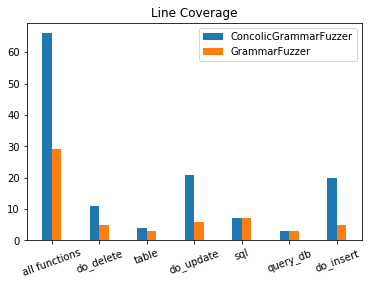

In [19]:
result_comparator.compare_line_coverage()

Looks like the `ConcolicGrammarFuzzer` is winning. This is what we expected because the concolic fuzzer should be able to figure out precise table/field names with the help of symbolic execution, and update its grammar in order produce better queries.

Let's see the branch coverage.



Branch Coverage                ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
all functions                  65                        25                       
do_delete                      10                        4                        
table                          4                         3                        
do_update                      20                        5                        
sql                            7                         7                        
query_db                       2                         2                        
do_insert                      22                        4                        


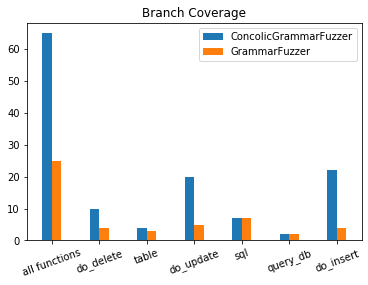

In [20]:
result_comparator.compare_branch_coverage()

This is similar to line coverage.

In [21]:
result_comparator.compare_exceptions()



Exception Type                 ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
all exceptions                 952                       1000                     
TypeError                      1                         0                        
SQLException                   951                       1000                     


Looks like both fuzzers had many `SQLException`s. We can see that the concolic fuzzer had some runs without any exceptions where as the grammar fuzzer had none. 

Let's now have a look at the valid inputs produced.

In [24]:
result_comparator.compare_valid_inputs()



Valid Inputs                   ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
Number                         48                        0                        
Percentage %                   4.8                       0.0                      


We can also see what exactly are these valid inputs.

In [25]:
result1.valid_inputs

['select (months+months*name),month<month,name from months where (8)==month!=month',
 "insert into months (name) values ('%7#A;')",
 'delete from months where month==1477.09',
 'select ((42.15)) from months',
 'select (month) from months',
 'select (((1.4))) from months',
 'select company from vehicles',
 'select month from months',
 'update vehicles set company=name,company=model:G where year==29.12',
 'delete from months where 3.67==(54)',
 'select 7 from vehicles',
 'select 2.52 from months',
 "insert into vehicles (kind) values ('@#')",
 "insert into vehicles (company) values ('P')",
 'delete from months where name!=-3',
 'delete from months where (name)==-473',
 "insert into vehicles (model) values ('^u')",
 "insert into vehicles (model) values ('%M<n')",
 "insert into vehicles (kind) values ('8')",
 'select 8.339563 from vehicles',
 'select year(year>company,name)-model+month+name-month+months*company/company-(9.1) from vehicles where 5==7',
 'insert into months (name) values (05

We see that the `ConcolicGrammarFuzzer` is able to update the grammar to include values that depend on the state of the database such as table names (`vehicles`, `months`, ...).

Let's check what is wrong with the inputs produced by the `GrammarFuzzer`.

In [26]:
result2.exceptions

[('select V from Q where c-K<k+W+Z/G*S(E,X)-G',
  InformationFlow.SQLException("Table ('Q') was not found")),
 ('select (W==F),B,: from D37 where .!=((Y/g))',
  InformationFlow.SQLException("Table ('D37') was not found")),
 ('delete from DXZ where j(W)<Wz(u,F)!=((B/L+f+x))',
  InformationFlow.SQLException("Table ('DXZ') was not found")),
 ('delete from q where L*y+n-r/L>v/K*N-Y(c)',
  InformationFlow.SQLException("Table ('q') was not found")),
 ("insert into W (e) values (2.85,'|+Xx',5.2,'x')",
  InformationFlow.SQLException("Table ('W') was not found")),
 ('update mM set :=mdeI6S where H*B<S/J>p(m,q)!=(Z)',
  InformationFlow.SQLException("Table ('mM') was not found")),
 ('select Q,O,WB,g(((R<K)*N+b-m+_<Z>f)) from MS2',
  InformationFlow.SQLException("Table ('MS2') was not found")),
 ("insert into h (HUqDgTj14,IH,a335) values ('n','5')",
  InformationFlow.SQLException("Table ('h') was not found")),
 ("insert into y2OTy (QhS5) values (-9,'s','{','i')",
  InformationFlow.SQLException("Ta

As we can see, the inputs are actually produced correctly according to the grammar. However, the grammar itself is not enough to produce inputs depending on the state of the database.

Let's compare the elapsed time for each fuzzer.

In [27]:
result_comparator.compare_elapsed_time()



Elapsed Time                   ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
in minutes                     2.08 m                    0.51 m                   
in seconds                     124.59 s                  30.41 s                  
in milliseconds                124594 ms                 30413 ms                 


As expected, concolic fuzzer runs much slower because of the concolic execution and the constraint solving.

Now, let's implement a function to encapsulate this comperative running process.

In [28]:
def comperative_run(runner1, config1, runner2, config2): 
    result1 = runner1(**config1)
    result2 = runner2(**config2)
    rc = ResultComparator(result1, result2)
    rc.compare_all()
    return result1, result2

Let's fuzz 2000 times and compare the results with the `comperative_run` function.

ConcolicGrammarFuzzer         -> fuzzed 2000 times in 234.26 seconds!
GrammarFuzzer                 -> fuzzed 2000 times in 54.62 seconds!


Line Coverage                  ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
all functions                  66                        29                       
do_delete                      11                        5                        
table                          4                         3                        
do_update                      21                        6                        
sql                            7                         7                        
query_db                       3                         3                        
do_insert                      20                        5                        


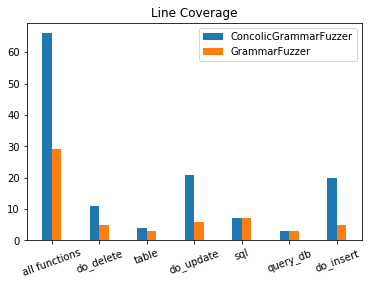



Branch Coverage                ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
all functions                  65                        25                       
do_delete                      10                        4                        
table                          4                         3                        
do_update                      20                        5                        
sql                            7                         7                        
query_db                       2                         2                        
do_insert                      22                        4                        


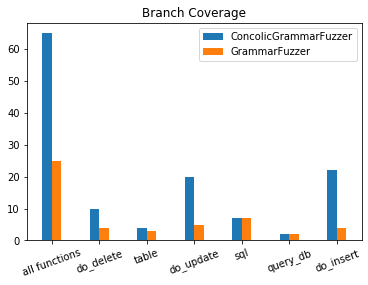



Exception Type                 ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
all exceptions                 1892                      2000                     
TypeError                      1                         0                        
SQLException                   1891                      2000                     


Valid Inputs                   ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
Number                         108                       0                        
Percentage %                   5.4                       0.0                      


Elapsed Time                   ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
in minutes                     3.90 m                    0.91 m                   
in seconds         

In [29]:
config = {
    'target': TARGET_DEFAULT,       # query_db
    'grammar': GRAMMAR_DEFAULT,     # INVENTORY_GRAMMAR
    'min_nonterminals': 0,          
    'max_nonterminals': 10,         
    'n_fuzz': 2000,                 
    'functions': FUNCTIONS_DEFAULT  # functions we want to obtain coverage
}

result1, result2 = comperative_run(
    runner1=run_concolic_grammar_fuzzer,
    config1=config,
    runner2=run_grammar_fuzzer,
    config2=config
)

Coverages are similar, but this time we got more valid inputs with the concolic fuzzer.

### Timed Fuzzing

So far we have fuzzed our target given number of times but it is also a nice idea to fuzz the target for a given duration. Let's add this with the following function `fuzz_n_minutes` and new runners `run_grammar_fuzzer_timed`, `run_concolic_grammar_fuzzer_timed`.

In [30]:
def fuzz_n_minutes(target, functions, fuzzer, n_minutes):
    fuzzer_name = fuzzer.__class__.__name__
    
    line_coverage = set()
    branch_coverage = set()
    exceptions = []
    valid_inputs = []
    
    start_time = time.time()
    stop_time_wanted = start_time + (n_minutes * 60)
    
    i = 0
    while True:
        remaining = stop_time_wanted - time.time()
        if remaining < 1:
            break
        
        print('{0:<30}-> fuzz {1} remaining {2:.0f} seconds'.format(
              fuzzer_name, i, remaining), end='  \r')
        
        inp = fuzzer.fuzz()
        with FilteredCoverage(functions) as fc:
            try:
                run_target(target, inp, fuzzer)
                valid_inputs.append(inp)
            except Exception as e:
                exceptions.append((inp, e))

        line_coverage |= fc.get_line_coverage()
        branch_coverage |= fc.get_branch_coverage()
        i += 1
        
    elapsed_time = time.time() - start_time

    print('{0:<30}-> fuzzed {1} times in {2:.2f} seconds!'.format(fuzzer_name, i, elapsed_time))
    
    return Result(functions,
                  fuzzer_name,
                  i,
                  line_coverage, 
                  branch_coverage, 
                  exceptions,
                  valid_inputs,
                  elapsed_time)

In [31]:
def run_grammar_fuzzer_timed(
        target, 
        grammar, 
        min_nonterminals,
        max_nonterminals,
        n_minutes,
        functions): 
    
    gf = GrammarFuzzer(grammar=grammar, 
                       min_nonterminals=min_nonterminals,
                       max_nonterminals=max_nonterminals)
    
    result = fuzz_n_minutes(target=target, 
                          functions=functions, 
                          fuzzer=gf, 
                          n_minutes=n_minutes)
    
    return result

In [32]:
def run_concolic_grammar_fuzzer_timed(
        target, 
        grammar, 
        min_nonterminals,
        max_nonterminals, 
        n_minutes,
        functions):
    
    cgf = ConcolicGrammarFuzzer(grammar=grammar,
                                min_nonterminals=min_nonterminals,
                                max_nonterminals=max_nonterminals)
    
    cgf.prune_tokens([])
    
    result = fuzz_n_minutes(target=target, 
                          functions=functions, 
                          fuzzer=cgf, 
                          n_minutes=n_minutes)
    
    return result

ConcolicGrammarFuzzer         -> fuzzed 510 times in 59.12 seconds!
GrammarFuzzer                 -> fuzzed 1842 times in 59.00 seconds!


Line Coverage                  ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
all functions                  60                        29                       
do_delete                      7                         5                        
table                          4                         3                        
do_update                      19                        6                        
sql                            7                         7                        
query_db                       3                         3                        
do_insert                      20                        5                        


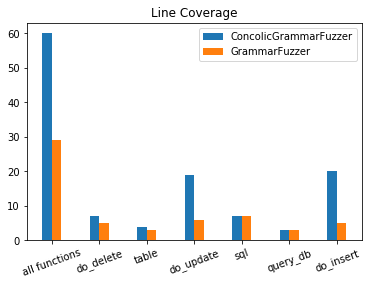



Branch Coverage                ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
all functions                  58                        25                       
do_delete                      5                         4                        
table                          4                         3                        
do_update                      18                        5                        
sql                            7                         7                        
query_db                       2                         2                        
do_insert                      22                        4                        


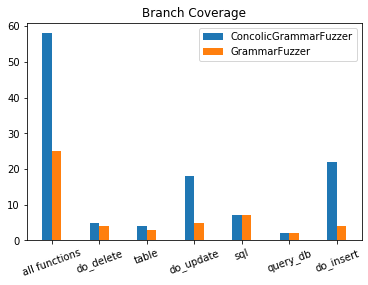



Exception Type                 ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
all exceptions                 485                       1842                     
SQLException                   485                       1842                     


Valid Inputs                   ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
Number                         25                        0                        
Percentage %                   4.9                       0.0                      


Elapsed Time                   ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
in minutes                     0.99 m                    0.98 m                   
in seconds                     59.12 s                   59.00 s                  
in milliseconds    

In [33]:
config = {
    'target': TARGET_DEFAULT,       
    'grammar': GRAMMAR_DEFAULT,     
    'min_nonterminals': 0,          
    'max_nonterminals': 10,         
    'n_minutes': 1,                 
    'functions': FUNCTIONS_DEFAULT  
}

result1, result2 = comperative_run(
    runner1=run_concolic_grammar_fuzzer_timed,
    config1=config,
    runner2=run_grammar_fuzzer_timed,
    config2=config
)

### Fuzzing for an hour with each fuzzer

Let's see if we gain new insights.

ConcolicGrammarFuzzer         -> fuzzed 32092 times in 3599.09 seconds!
GrammarFuzzer                 -> fuzzed 134744 times in 3599.03 seconds!                                                     


Line Coverage                  ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
all functions                  66                        29                       
do_delete                      11                        5                        
table                          4                         3                        
do_update                      21                        6                        
sql                            7                         7                        
query_db                       3                         3                        
do_insert                      20                        5                        


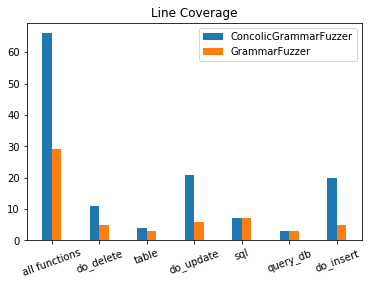



Branch Coverage                ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
all functions                  65                        25                       
do_delete                      10                        4                        
table                          4                         3                        
do_update                      20                        5                        
sql                            7                         7                        
query_db                       2                         2                        
do_insert                      22                        4                        


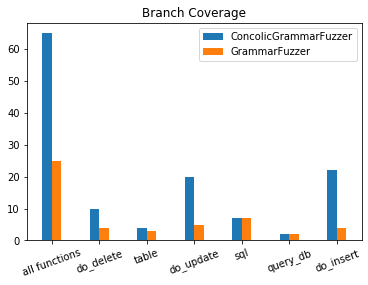



Exception Type                 ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
all exceptions                 30348                     134744                   
TypeError                      23                        0                        
SQLException                   30325                     134744                   


Valid Inputs                   ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
Number                         1744                      0                        
Percentage %                   5.43                      0.0                      


Elapsed Time                   ConcolicGrammarFuzzer     GrammarFuzzer            
---------------------------------------------------------------------------
in minutes                     59.98 m                   59.98 m                  
in seconds         

In [34]:
config = {
    'target': TARGET_DEFAULT,       
    'grammar': GRAMMAR_DEFAULT,     
    'min_nonterminals': 0,         
    'max_nonterminals': 10,         
    'n_minutes': 60,            
    'functions': FUNCTIONS_DEFAULT
}

result1, result2 = comperative_run(
    runner1=run_concolic_grammar_fuzzer_timed,
    config1=config,
    runner2=run_grammar_fuzzer_timed,
    config2=config
)

## 7. Comments, Conclusion and Future Work <a name="comments"></a>

### Speed
* `GrammarFuzzer` runs ~4 times faster than `ConcolicGrammarFuzzer`.
* `ConcolicGrammarFuzzer`'s is limited by concolic execution, constraint solving, z3, theory of strings ...

### Inputs produced and coverage
* `ConcolicGrammarFuzzer` is able to generate inputs that **depend on the state**.

* Not only uses the given grammar, but updates it with the help of the concolic execution and the constraint solver (e.g adds required table and column names which depend on the state of the database).

* Hence, `ConcolicGrammarFuzzer` is able to produce **valid inputs** and achieves a **higher coverage**.

* On the other hand, `GrammarFuzzer` works only with the information provided by the grammar. Therefore it can't generate inputs that depend on the state of the database.

### Obtaining Coverage
* Obtaining coverage from concolic execution requires some extra work.
* I chose whitelisting the functions because it is simpler and suitable for the target program in this evaluation. 
* Downside of whitelisting is that we need to know the functions we are interested **beforehand**. 
* Blacklisting might also work, but is much harder to implement (because of all the wrapping in concolic execution).

### Future work

* `ConcolicGrammarFuzzer` can be improved with the advances in SMT solvers.

* Should test fuzzing other programs too. Any program with a changing state might be a good candidate (e.g. web applications, file systems, CISCO routers, FTP, IMAP...)